## LLM

In [1]:
#import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
#from src.tokenizer import TokenizerBPE, fuse_tokenized_corpus, chunk_corpus

#import matplotlib as plt
import os
import time
import torch as torch
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.transformer import Transformer
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Categorical
from src.utils import loader, saver

print("PyTorch version:", torch.__version__)  
print("CUDA toolkit version PyTorch was built with:", torch.version.cuda)  
print("cuDNN version:", torch.backends.cudnn.version()) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.7.1+cu128
CUDA toolkit version PyTorch was built with: 12.8
cuDNN version: 90701


In [2]:
tokenizer = loader("corpus/tokenizer_bpe_32000.pkl")
tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>", "<pad>"])

In [3]:
coqa = loader("corpus/coqa_bpe_32000_packed.pt")
coqa = torch.tensor(coqa)

math = loader("corpus/math_bpe_32000_packed.pt")
math = torch.tensor(math)

hotpot = loader("corpus/hotpot_bpe_32000_packed.pt")
hotpot = torch.tensor(hotpot)

hotpot_noRed = loader("corpus/hotpot_noRed_bpe_32000_packed.pt")
hotpot_noRed = torch.tensor(hotpot_noRed)

quac = loader("corpus/quac_bpe_32000_packed.pt")
quac = torch.tensor(quac)

squad = loader("corpus/squad_bpe_32000_packed.pt")
squad = torch.tensor(squad)

recipe = loader("corpus/recipe_bpe_32000.pkl")
recipe = torch.tensor(recipe)
recipe = recipe[:-(len(recipe) % 1024)].reshape(-1, 1024)

recipe_qa = loader("corpus/recipe_qa_bpe_32000.pkl")
recipe_qa = torch.tensor(recipe_qa)
recipe_qa = recipe_qa[:-(len(recipe_qa) % 1024)].reshape(-1, 1024)

recipe_qa_ingred = loader("corpus/recipe_qa_ingred_bpe_32000.pkl")
recipe_qa_ingred = torch.tensor(recipe_qa_ingred)
recipe_qa_ingred = recipe_qa_ingred[:-(len(recipe_qa_ingred) % 1024)].reshape(-1, 1024)

trivia_web = loader("corpus/trivia_web_bpe_32000.pkl")
trivia_web.pop(22177)
trivia_web = [torch.tensor(t) for t in trivia_web]
trivia_web = torch.concat(trivia_web, dim=0)
trivia_web_1 = trivia_web[:-(len(trivia_web) % 1024)].reshape(-1, 1024)
trivia_web_2 = trivia_web[512:-((len(trivia_web)-512) % 1024)].reshape(-1, 1024)

trivia_wiki = loader("corpus/trivia_wiki_bpe_32000.pkl")
trivia_wiki = [torch.tensor(t) for t in trivia_wiki]
trivia_wiki = torch.concat(trivia_wiki, dim=0)
trivia_wiki_1 = trivia_wiki[:-(len(trivia_wiki) % 1024)].reshape(-1, 1024)
trivia_wiki_2 = trivia_wiki[512:-((len(trivia_wiki)-512) % 1024)].reshape(-1, 1024)

trivia_web_qa_packed = loader("corpus/trivia_web_qa_bpe_32000_packed.pt")
trivia_web_qa_packed = torch.tensor(trivia_web_qa_packed)

trivia_wiki_qa_packed = loader("corpus/trivia_wiki_qa_bpe_32000_packed.pt")
trivia_wiki_qa_packed = torch.tensor(trivia_wiki_qa_packed)

corpus = torch.concat([
    coqa, math, hotpot, quac, squad, recipe, recipe_qa, recipe_qa_ingred, trivia_web_1, trivia_web_2, trivia_wiki_1, trivia_wiki_2, trivia_web_qa_packed, trivia_wiki_qa_packed
], dim=0)
print(corpus.shape[0]*corpus.shape[1])

loader_train = DataLoader(
    corpus,
    batch_size=2,
    shuffle=True,       # shuffle every epoch
    drop_last=False     # whether to drop the tail batch if smaller than batch_size
)

/tmp/ipykernel_284865/1795775070.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coqa = torch.tensor(coqa)
/tmp/ipykernel_284865/1795775070.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  math = torch.tensor(math)
/tmp/ipykernel_284865/1795775070.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hotpot = torch.tensor(hotpot)
/tmp/ipykernel_284865/1795775070.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than

824579072


In [4]:
accum_steps = 16

@torch.compile
def forward_and_loss(model, batch, criterion):
    model.train()
    #batch is a tensor of shape [batch, seq]
    src, tgt = batch[:, :-1].to(device), batch[:, 1:].to(device)
    logits = model(src)
    return criterion(logits.reshape(-1, logits.size(-1)), tgt.reshape(-1))


def train_step(model, batch, criterion, optimizer, scaler, scheduler, i):
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        loss = forward_and_loss(model, batch, criterion)

    scaler.scale(loss/accum_steps).backward()

    if (i+1)%accum_steps == 0:
        scaler.step(optimizer)
        scheduler.step()
        scaler.update()
        optimizer.zero_grad()

    return loss


warmup_steps    = 1000

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    return 1.0

In [5]:
embed_dim = 64*20
ff_dim = 4*embed_dim
heads = 20
tf_blocks = 20


transformer = Transformer(
    embed_dim=embed_dim,
    ff_dim=ff_dim,
    heads=heads,
    tf_blocks=tf_blocks,
    vocab_size=tokenizer.vocab_size,
    max_seq_len=1024,
    dropout=0.1,
    pad_token_id=None,
    start_token_id=tokenizer.token_to_idx["<s>"],
).to(device)

with torch.no_grad():
    # Initialize embedding weights properly
    torch.nn.init.normal_(transformer.word_embed.weight, mean=0.0, std=0.01)
    torch.nn.init.normal_(transformer.pos_embed.weight, mean=0.0, std=0.01)

In [6]:
param_optimizer = list(transformer.named_parameters())

no_decay = ['bias', 'LayerNorm.weight'] # Parameters to exclude from weight decay

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.01}, # Apply weight decay to these parameters
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0} # No weight decay for these parameters
]

In [7]:
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5)
scaler = torch.amp.GradScaler("cuda")
loss_history = []

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Make Checkpoint

In [8]:
name = "models/slarn_29_06_2025_ckpt.pt"

In [ ]:
""" checkpoint = {
    "model":      transformer.state_dict(),
    "optimizer":  optimizer.state_dict(),
    "scheduler":  scheduler.state_dict(),
    "losses":     loss_history,      # plain list or numpy array is fine
}

torch.save(checkpoint, name) """

In [12]:
### Load Checkpoint

In [ ]:
ckpt = torch.load(name, map_location="cpu")

transformer.load_state_dict(ckpt["model"])
optimizer.load_state_dict(ckpt["optimizer"])
for state in optimizer.state.values():        # move internal momenta to GPU
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
scheduler.load_state_dict(ckpt["scheduler"])
loss_history = ckpt["losses"]

In [60]:
criterion = torch.nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler("cuda")
name = "models/slarn_30_06_2025_ckpt.pt"
accum_steps = 32

optimizer.zero_grad()
for e in range(1):
    loss_temp = 0
    for i, (batch) in tqdm(enumerate(loader_train), total=len(loader_train), desc="Training"):
        
            batch = batch.to(device)
            loss = train_step(transformer, batch, criterion, optimizer, scaler, scheduler, i)
            loss_temp += loss.item()
            if (i+1)%accum_steps == 0:
                lr = scheduler.get_last_lr()[0]
                loss_mean = loss_temp/accum_steps
                print(f"Step {i}, Loss: {loss_mean:.4f}, LR: {lr}")
                loss_history.append(loss_mean)
                loss_temp = 0

            if (i+1)%5000 == 0:
                 checkpoint = {
                                "model":      transformer.state_dict(),
                                "optimizer":  optimizer.state_dict(),
                                "scheduler":  scheduler.state_dict(),
                                "losses":     loss_history,      # plain list or numpy array is fine
                              }
                 torch.save(checkpoint, name)
                 
    checkpoint = {
                    "model":      transformer.state_dict(),
                    "optimizer":  optimizer.state_dict(),
                    "scheduler":  scheduler.state_dict(),
                    "losses":     loss_history,      # plain list or numpy array is fine
                    }
    torch.save(checkpoint, name)

Training:   0%|          | 0/402627 [00:00<?, ?it/s]

Step 31, Loss: 3.5428, LR: 5e-05
Step 63, Loss: 3.4978, LR: 5e-05
Step 95, Loss: 3.5754, LR: 5e-05
Step 127, Loss: 3.5662, LR: 5e-05
Step 159, Loss: 3.6142, LR: 5e-05
Step 191, Loss: 3.6724, LR: 5e-05
Step 223, Loss: 3.5425, LR: 5e-05
Step 255, Loss: 3.6465, LR: 5e-05
Step 287, Loss: 3.4334, LR: 5e-05
Step 319, Loss: 3.5609, LR: 5e-05
Step 351, Loss: 3.3782, LR: 5e-05
Step 383, Loss: 3.4396, LR: 5e-05
Step 415, Loss: 3.5589, LR: 5e-05
Step 447, Loss: 3.4534, LR: 5e-05
Step 479, Loss: 3.6286, LR: 5e-05
Step 511, Loss: 3.5878, LR: 5e-05
Step 543, Loss: 3.3102, LR: 5e-05
Step 575, Loss: 3.2320, LR: 5e-05
Step 607, Loss: 3.5832, LR: 5e-05
Step 639, Loss: 3.6719, LR: 5e-05
Step 671, Loss: 3.6469, LR: 5e-05
Step 703, Loss: 3.5602, LR: 5e-05
Step 735, Loss: 3.3755, LR: 5e-05
Step 767, Loss: 3.5206, LR: 5e-05
Step 799, Loss: 3.6925, LR: 5e-05
Step 831, Loss: 3.5641, LR: 5e-05
Step 863, Loss: 3.6161, LR: 5e-05
Step 895, Loss: 3.5871, LR: 5e-05
Step 927, Loss: 3.5763, LR: 5e-05
Step 959, Loss: 3

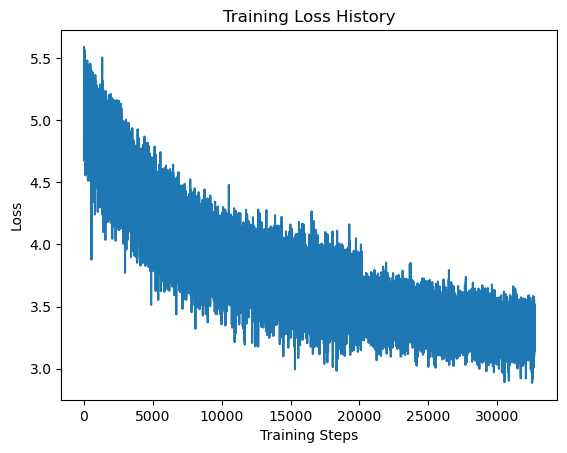

In [61]:
plt.plot(loss_history[5000:])
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.show()

In [86]:
import textwrap
import ipywidgets as widgets
from IPython.display import display

text = "<s><q>who is obama?"
tokens = torch.tensor(tokenizer.encode(text), dtype=torch.long).unsqueeze(0).to(device)

wrapper = textwrap.TextWrapper(width=80)

ta = widgets.Textarea(
    value="",
    layout=widgets.Layout(width='80ch', height='20em'),
    disabled=True
)
display(ta)

T, k = 1, 50
max_len = 1024

transformer.eval()                 # turn off dropout etc.

with torch.inference_mode():       # ⚡ no autograd & a little faster
    for _ in range(max_len):
        logits = transformer(tokens)[:, -1]          # shape (1, vocab)
        topk_vals, _ = torch.topk(logits, k=k)
        kth_value    = topk_vals[:, -1]

        logits = torch.where(logits >= kth_value, logits, -torch.inf)
        dist   = torch.distributions.Categorical(logits=logits / T)
        idx    = dist.sample()

        # grow the sequence *after* we’ve sampled
        tokens = torch.cat([tokens, idx.unsqueeze(0)], dim=1)

        text = tokenizer.decode(tokens[0].cpu().numpy())
        ta.value = wrapper.fill(text.replace("\n", " "))

        if idx.item() == tokenizer.token_to_idx["</s>"]:
            break


Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))